### ToDo

- Index with session again, and check whether they get slower of the trial of the session

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
from typing import Optional, Dict, List, Union


def create_circular_diagram_from_df(
    ax: plt.Axes,
    df: pd.DataFrame,
    arrangement: Union[str, List[int]] = 'most_common',
    ignore_state: int = 0,
    radius: float = 0.4,
    node_size: float = 0.08,
    font_size: int = 10,
    motif_mapping: Optional[Dict[int, Dict]] = None,
) -> plt.Axes:
    """
    Create circular transition diagram from DataFrame with sequences.
    
    Parameters
    ----------
    ax : plt.Axes
        Matplotlib axes to draw on
    df : pd.DataFrame
        DataFrame with sequences
    arrangement : str or List[int]
        How to arrange nodes:
        - 'most_common': arrange by most common sequence
        - List[int]: custom order of states
    ignore_state : int
        State to ignore (default: 0)
    radius : float
        Circle radius (default: 0.4)
    node_size : float
        Node size (default: 0.08)
    font_size : int
        Font size for labels (default: 10)
    motif_mapping : Dict[int, Dict], optional
        Dictionary mapping states to {'name': str, 'color': array}

    
    Returns
    -------
    ax : plt.Axes
        Modified axes with diagram
    """
    
    # Extract sequences and weights
    sequences = df['sequence'].tolist()
    weights = df['count'].tolist() if 'count' in df else [1] * len(sequences)

    # Extract all transitions with weights
    transition_counts = Counter()
    state_frequencies = Counter()
    
    for seq, weight in zip(sequences, weights):
        # Track state frequencies
        for state in seq:
            if state != ignore_state:
                state_frequencies[state] += weight
        
        # Extract transitions
        prev = None
        for state in seq:
            if state != ignore_state:
                if prev is not None and prev != state:
                    transition_counts[(prev, state)] += weight
                prev = state
            else:
                prev = None
    
    if not transition_counts:
        ax.text(0.5, 0.5, "No transitions found!", 
                ha='center', va='center', transform=ax.transAxes)
        return ax
    
    # Determine node order based on arrangement parameter
    if isinstance(arrangement, list):
        # Custom order provided
        unique_states = [s for s in arrangement if s in state_frequencies]
    elif arrangement == 'most_common':
        # Order by most common sequence
        if sequences:
            most_common_seq = sequences[0]  # First sequence has highest count
            unique_states = []
            seen = set()
            for state in most_common_seq:
                if state != ignore_state and state not in seen:
                    unique_states.append(state)
                    seen.add(state)
            # Add any remaining states
            for state in sorted(state_frequencies.keys()):
                if state not in seen:
                    unique_states.append(state)
    else:
        # Default: sorted order
        unique_states = sorted(state_frequencies.keys())
    
    n_states = len(unique_states)
    
    # Create circular positions
    angles = np.linspace(0, 2*np.pi, n_states, endpoint=False)
    positions = {}
    for i, state in enumerate(unique_states):
        x = radius * np.cos(angles[i])
        y = radius * np.sin(angles[i])
        positions[state] = (x, y)
    
    # Draw edges
    max_weight = max(transition_counts.values())
    
    for (src, tgt), weight in transition_counts.items():
        x1, y1 = positions[src]
        x2, y2 = positions[tgt]
        
        if src == tgt:  # Self-loop
            loop_center = (x1 * 1.4, y1 * 1.4)
            circle = mpatches.Circle(
                loop_center, 0.1,
                fill=False,
                edgecolor='gray',
                linewidth=0.5 + weight/max_weight*3,
                alpha=0.7
            )
            ax.add_patch(circle)
            # Add count label on the self-loop
            ax.text(loop_center[0], loop_center[1], str(weight),
                   fontsize=8, ha='center', va='center',
                   color='black',
                   weight='bold',
                   bbox=dict(boxstyle='round,pad=0.2', 
                            facecolor='white', alpha=0.9))
        else:
            # Curved arrow
            arrow = mpatches.FancyArrowPatch(
                (x1, y1), (x2, y2),
                connectionstyle="arc3,rad=.3",
                arrowstyle='-|>',
                mutation_scale=15,
                linewidth=0.5 + weight/max_weight*3,
                color='gray',
                alpha=0.6
            )
            ax.add_patch(arrow)
            
            # Calculate position along the arc for label
            # Get control point for the arc
            dx = x2 - x1
            dy = y2 - y1
            dist = np.sqrt(dx**2 + dy**2)
            
            # Perpendicular vector for arc offset
            perp_x = -dy / dist * 0.15
            perp_y = dx / dist * 0.15
            
            # Position at midpoint of arc
            mid_x = (x1 + x2) / 2 + perp_x
            mid_y = (y1 + y2) / 2 + perp_y
            
            # Add number directly on the arrow path
            ax.text(mid_x, mid_y, str(weight),
                   fontsize=8, ha='center', va='center',
                   color='black',
                   weight='bold',
                   bbox=dict(boxstyle='round,pad=0.15', 
                            facecolor='white', alpha=0.9))
    
    # Draw nodes
    for state, (x, y) in positions.items():
        # Get color from motif mapping
        if motif_mapping and state in motif_mapping:
            color = motif_mapping[state]['color']
            # Ensure color is in correct format (convert numpy array if needed)
            if hasattr(color, '__iter__'):
                color = tuple(color)
        else:
            # Default color scheme if no mapping provided
            color = plt.cm.tab20(state % 20)[:3]
        
        # Draw node
        circle = plt.Circle(
            (x, y), node_size,
            color=color,
            ec='black',
            linewidth=2,
            zorder=10
        )
        ax.add_patch(circle)
        
        # Node label - show state number
        text_color = 'white' if np.mean(color) < 0.5 else 'black'
        ax.text(x, y, str(state),
               fontsize=font_size,
               ha='center', va='center',
               weight='bold',
               color=text_color,
               zorder=11)
    
    # Set axis properties
    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(-0.7, 0.7)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add title
    total_transitions = sum(transition_counts.values())
    ax.set_title(
        f"State Transition Diagram\n"
        f"{n_states} states, {total_transitions} transitions",
        fontsize=12,
        pad=20
    )
    

    return ax

In [ ]:
paths = [r"C:\Users\FM\Desktop\trainFreddy\Trial_data_Freddy2701.nc",
         r"C:\Users\FM\Desktop\trainFreddy\Trial_data_Freddy2702.nc",
         r"C:\Users\FM\Desktop\trainFreddy\Trial_data_Freddy2801.nc"]
        

# 2019528keypoints
# 544952keypoints
merge_dict = {}

for i, path in enumerate(paths):
    dt_temp = TrialTree.load(path)
    
    merge_dict[f"session_{i}"] = dt_temp


dt = TrialTree.merge_session_trees(merge_dict)
ds = dt.stack_session(
    concat_dim="trials",
    keep_vars=["labels", "speed"],
    # attrs_to_vars=["poscat", "num_pellets"]
)
# ds = ds.where(ds.poscat.isin([1, 3]), drop=True)
# ds = ds.where(ds.num_pellets == 1, drop=True)
# ds = ds.sel(individuals="Freddy")
# ds.to_netcdf("labels_ds.nc")

NameError: name 'TrialTree' is not defined

In [ ]:
ds_stacked = ds.stack(observations=("trials", "time"))
ds_stacked

<xarray.Dataset> Size: 95MB
Dimensions:       (individuals: 1, observations: 1694961, keypoints: 3)
Coordinates:
  * keypoints     (keypoints) <U8 96B 'beakTip' 'stickTip' 'pellet'
  * individuals   (individuals) <U6 24B 'Freddy'
  * observations  (observations) object 14MB MultiIndex
  * trials        (observations) int64 14MB 0 0 0 0 0 0 ... 422 422 422 422 422
  * time          (observations) float64 14MB 0.0 0.005 0.01 ... 20.02 20.03
Data variables:
    labels        (individuals, observations) float64 14MB 0.0 0.0 ... 0.0 nan
    speed         (keypoints, individuals, observations) float64 41MB nan ......
Attributes:
    source_software:  DeepLabCut
    ds_type:          poses
    fps:              200.0
    time_unit:        seconds
    bird:             Freddy
    cameras:          ['cam1_file', 'cam2_file']
    tracking:         ['dlc1_file', 'dlc2_file']

In [8]:
ds = xr.concat(ds, dim="trials")
ds

TypeError: can only concatenate xarray Dataset and DataArray objects, got <class 'str'>

In [4]:
ds = xr.open_dataset("labels_ds.nc")

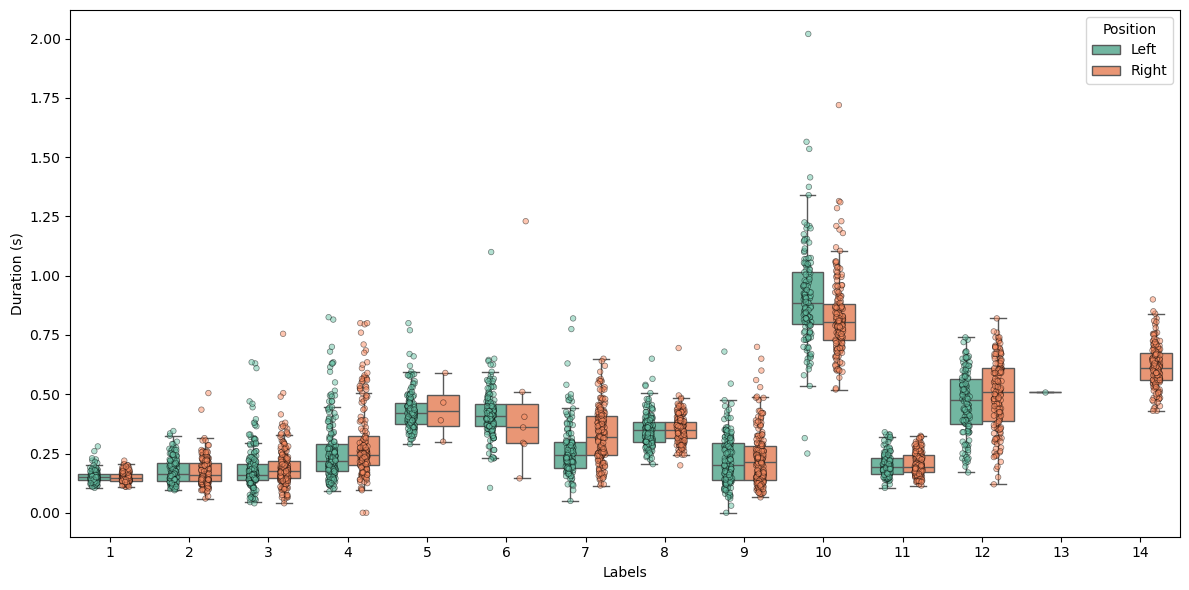

In [113]:
fig, ax = plt.subplots(figsize=(12, 6))


sns.boxplot(data=df, x='label', y='duration', hue='poscat',
            ax=ax, palette='Set2', showfliers=False)  # Hide outliers since stripplot shows all points


sns.stripplot(data=df, x='label', y='duration', hue='poscat',
              dodge=True, alpha=0.5, size=4, ax=ax, 
              palette='Set2', edgecolor='black', linewidth=0.5)

ax.set_ylabel('Duration (s)')
ax.set_xlabel('Labels')


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], ['Left', 'Right'], title='Position')

plt.tight_layout()
plt.show()

In [ ]:
df = ds_to_df(ds)
df.sequence.value_counts()
counts = df.sequence.value_counts()
first_two = counts.iloc[:2].sum()
others = counts.iloc[2:].sum()
percentage = first_two / (first_two + others) * 100
print(f"Percentage canoncical (top 2): {percentage:.2f}%")
print(df.sequence.value_counts())

left_canonical = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
right_canonical = [1, 2, 3, 4, 14, 7, 8, 9, 10, 11, 12]

Percentage canoncical (top 2): 48.57%
sequence
[1, 2, 3, 4, 14, 7, 8, 9, 10, 11, 12]         1210
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]        636
[1, 2, 3, 3, 4, 14, 7, 8, 9, 10, 11, 12]       216
[1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 10, 11, 12]     169
[1, 2, 3, 4, 4, 5, 6, 7, 8, 9, 10, 11, 12]     156
                                              ... 
[1, 2, 3, 4, 14, 7, 8, 9, 10, 6]                10
[1, 2, 4, 14, 7, 8, 9, 10, 11, 12]              10
[1, 2, 3, 14, 7, 8, 9, 10, 11, 2]               10
[1, 12, 3, 4, 14, 8, 9, 10, 11, 12]             10
[1, 2, 3, 3, 4, 14, 7, 8, 9, 10]                10
Name: count, Length: 64, dtype: int64


#### Get multiple trails per percentile and add error bars, one needs to bin the percentiles from to

2025-09-18 20:43:02.293 | WARNING  | matplotlib._api:warn_external:391 - C:\Users\aksel\AppData\Local\Temp\ipykernel_15932\3500754150.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



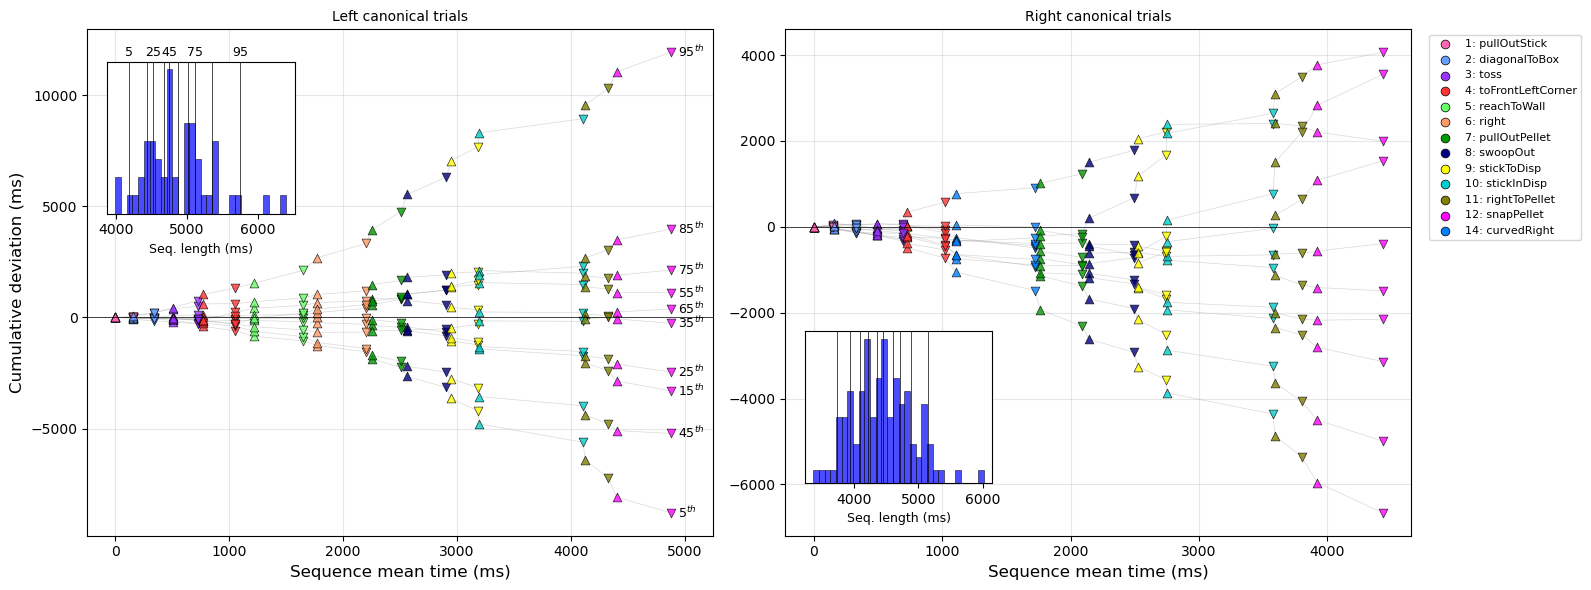

In [33]:

motif_mapping = load_motif_mapping(r"C:\Users\aksel\Documents\Code\movformer\mapping.txt")
fig, axes = plot_cumulative_deviations(df, left_canonical, right_canonical, motif_mapping)


### cumulative crossing testing

In [ ]:
def create_toy_data_with_crossing():
    """Create toy data with crossing patterns like real data."""
    
    canonical = [1, 2, 3, 4, 5, 6]
    n_events = len(canonical) * 2
    n_trials = 50
    
    # Create base timeline
    base_timeline = []
    for i in range(len(canonical)):
        onset = i * 0.5
        offset = onset + 0.2
        base_timeline.extend([onset, offset])
    
    data = []
    for trial_idx in range(n_trials):
        percentile = (trial_idx / n_trials) * 100
        
        # Create complex tempo patterns that can cross
        if trial_idx % 10 == 4:  # ~45th percentile trials
            # These trials start very fast then slow down dramatically
            event_times = []
            for i, t in enumerate(base_timeline):
                if i < 6:  # First half - very fast
                    tempo_factor = 0.6
                else:  # Second half - normal/slow
                    tempo_factor = 1.2
                event_times.append(t * tempo_factor)
        else:
            # Other trials have more uniform scaling
            base_tempo = 0.8 + (percentile / 100) * 0.4
            # Add some variation
            if trial_idx % 3 == 0:
                # Fast start, slow end
                event_times = [t * (base_tempo - 0.1 + i*0.02) for i, t in enumerate(base_timeline)]
            elif trial_idx % 3 == 1:
                # Slow start, fast end  
                event_times = [t * (base_tempo + 0.1 - i*0.02) for i, t in enumerate(base_timeline)]
            else:
                # Uniform
                event_times = [t * base_tempo for t in base_timeline]
        
        # Add noise
        noise = np.random.normal(0, 0.005, n_events)
        event_times = [t + n for t, n in zip(event_times, noise)]
        
        sequence_len = event_times[-1]
        poscat_value = 1.0 if trial_idx < 25 else 3.0
        
        for syll_idx, syllable in enumerate(canonical):
            start_idx = syll_idx * 2
            stop_idx = start_idx + 1
            
            data.append({
                'trial': trial_idx,
                'label': syllable,
                'poscat': poscat_value,
                'sequence': canonical.copy(),
                'event_times': event_times.copy(),
                'sequence_len': sequence_len,
                'num_pellets': 1.0,
                'start': event_times[start_idx],
                'stop': event_times[stop_idx],
                'duration': event_times[stop_idx] - event_times[start_idx]
            })
    
    df = pd.DataFrame(data)
    
    print("Created toy data with crossing patterns:")
    print("- Some trials (like P45) have extreme tempo changes mid-sequence")
    print("- This causes lines to cross in cumulative deviation plot")
    print("- Mimics the pattern you see in real data")
    
    return df

# Create toy data
toy_df = create_toy_data_with_crossing()



# Create motif mapping for labels 1-6
toy_motif_mapping = {
    i: {'name': f'syllable_{i}', 'color': np.array([i/6, 0.5, 1-i/6])}
    for i in range(1, 7)
}

toy_df_crossing = create_toy_data_with_crossing()
fig, axes, trial_data = plot_cumulative_deviations(
    toy_df_crossing,
    left_canonical=[1, 2, 3, 4, 5, 6],
    right_canonical=[1, 2, 3, 4, 5, 6],
    motif_mapping=toy_motif_mapping
)

#### Can I do this analyis separately (or jointly) on different syllable sequences, and then aggregate result

In [82]:
def calculate_elasticity(intervals: np.ndarray, sequence_lengths: np.ndarray) -> Dict[str, np.ndarray]:
    """
    Calculate elasticity coefficients for intervals.
    
    Args:
        intervals: Array of interval lengths (n_sequences, n_intervals)
        sequence_lengths: Array of total sequence lengths (n_sequences,)
    
    Returns:
        Dictionary with elasticities, coefficients, residuals
    """
    n_sequences, n_intervals = intervals.shape
    
    elasticities = np.zeros(n_intervals)
    coefficients = np.zeros(n_intervals)
    residuals = np.zeros((n_sequences, n_intervals))
    
    for i in range(n_intervals):
        xi = intervals[:, i]
        z = sequence_lengths
        
        # Linear regression: xi = ai + bi*z
        slope, intercept = np.polyfit(z, xi, 1)
        coefficients[i] = slope
        
        # Calculate residuals
        predicted = intercept + slope * z
        residuals[:, i] = xi - predicted
        
        # Normalized elasticity: λi = bi * (z̄/x̄i)
        elasticities[i] = slope * (np.mean(z) / np.mean(xi))
    
    return {
        'elasticities': elasticities,
        'coefficients': coefficients,
        'residuals': residuals
    }



def prepare_interval_data(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Extract intervals from segment DataFrame for elasticity analysis.
    
    Returns:
        (syllable_durations, gap_durations, sequence_lengths)
    """
    trial_groups = df.groupby('trial')
    
    all_syllables = []
    all_gaps = []
    all_lengths = []
    
    for trial_id, group in trial_groups:
        # group = group.sort_values('start')
        
        syllable_durations = group['duration'].values
        
        # Calculate gaps between syllables
        gaps = []
        for i in range(len(group) - 1):
            gap = group.iloc[i + 1]['start'] - group.iloc[i]['stop']
            gaps.append(gap)
        
        # Pad gaps to match syllable count
        gaps.append(0)  # No gap after last syllable
        
        all_syllables.append(syllable_durations)
        all_gaps.append(gaps)
        all_lengths.append(group.iloc[0]['sequence_len'])
    
    # Convert to arrays, padding to max length
    max_len = max(len(s) for s in all_syllables)
    
    syllable_array = np.array([np.pad(s, (0, max_len - len(s)), constant_values=np.nan) 
                                for s in all_syllables])
    gap_array = np.array([np.pad(g, (0, max_len - len(g)), constant_values=np.nan) 
                          for g in all_gaps])
    length_array = np.array(all_lengths)
    
    return syllable_array, gap_array, length_array

    """Analyze elasticity for trials with canonical sequence."""
    
    # Filter for canonical trials
    canonical_df = df[df['sequence'].apply(lambda x: x == canonical_sequence)]
    
    syllable_durations, gap_durations, sequence_lengths = prepare_interval_data(canonical_df)
    
    # Combine syllables and gaps into alternating intervals
    n_sequences = len(sequence_lengths)
    n_syllables = syllable_durations.shape[1]
    intervals = np.zeros((n_sequences, n_syllables * 2))
    
    for i in range(n_syllables):
        intervals[:, i * 2] = syllable_durations[:, i]
        intervals[:, i * 2 + 1] = gap_durations[:, i]
    
    # Calculate elasticities
    results = calculate_elasticity(intervals, sequence_lengths)
    
    # Test proportional scaling
    violations = test_proportional_scaling(intervals, sequence_lengths)
    
    # Analyze syllable-gap pairs
    pair_elasticities = []
    for i in range(n_syllables):
        if i * 2 + 1 < intervals.shape[1]:
            pair_e, w1, w2 = calculate_pair_elasticity(intervals, sequence_lengths, i * 2, i * 2 + 1)
            pair_elasticities.append(pair_e)
    
    return {
        'elasticities': results['elasticities'],
        'violations': violations,
        'pair_elasticities': np.array(pair_elasticities),
        'mean_elasticity': np.mean(results['elasticities'][~np.isnan(results['elasticities'])]),
        'residual_correlations': np.corrcoef(results['residuals'].T)
    }

2025-09-18 21:22:03.783 | WARNING  | __main__:calculate_elasticity:31 - C:\Users\aksel\AppData\Local\Temp\ipykernel_15932\1569991318.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  elasticities[i] = slope * (np.mean(z) / np.mean(xi))

2025-09-18 21:22:03.784 | WARNING  | __main__:calculate_elasticity:31 - C:\Users\aksel\AppData\Local\Temp\ipykernel_15932\1569991318.py:31: RuntimeWarning: invalid value encountered in scalar multiply
  elasticities[i] = slope * (np.mean(z) / np.mean(xi))



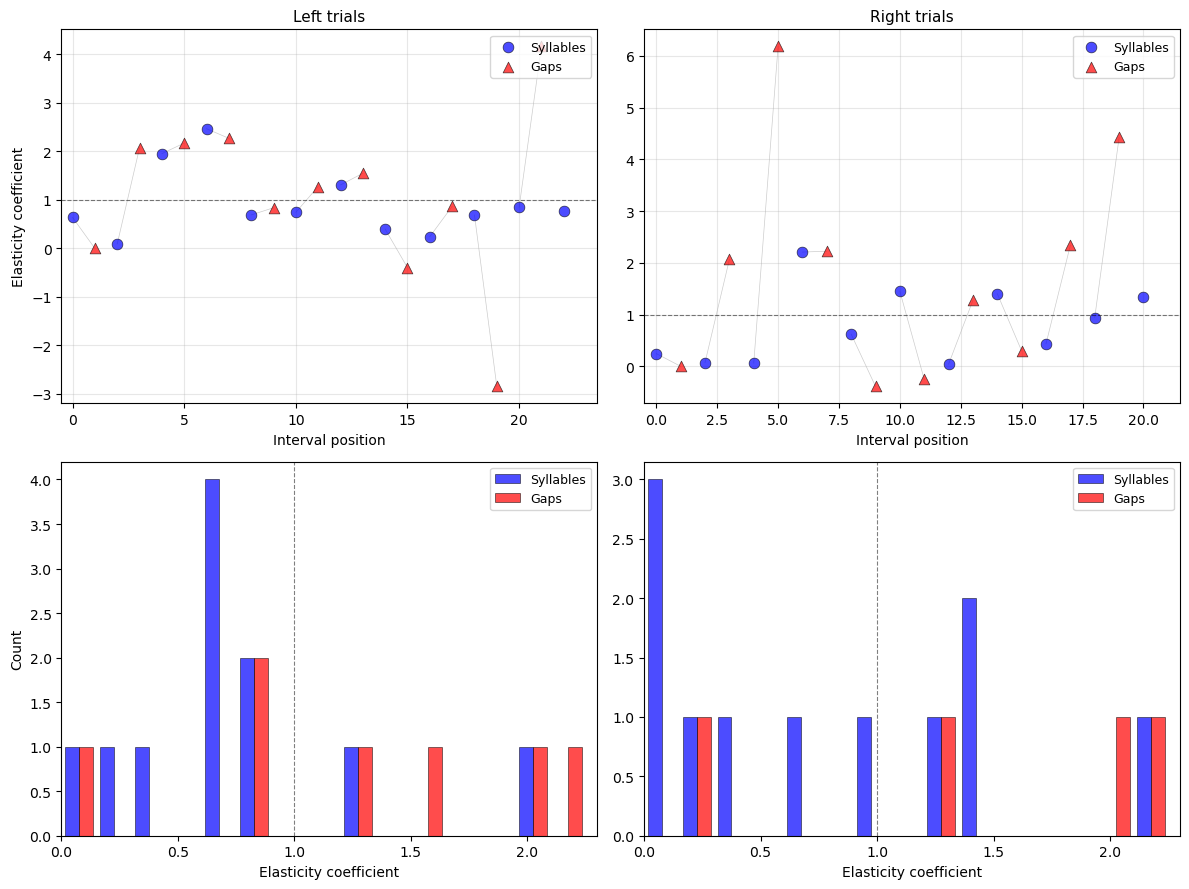

In [108]:
left_canonical = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
right_canonical = [1, 2, 3, 4, 14, 7, 8, 9, 10, 11, 12]

fig, axes = plt.subplots(2, 2, figsize=(12, 9))

for col, (poscat, canonical, title) in enumerate([
    (1.0, left_canonical, 'Left trials'),
    (3.0, right_canonical, 'Right trials')
]):
    # Filter data
    poscat_df = df[df['poscat'] == poscat].copy()
    canonical_df = poscat_df[poscat_df['sequence'].apply(lambda x: x == canonical)]
    
    if len(canonical_df) == 0:
        print(f"No canonical trials found for {title}")
        continue
    
    # Extract intervals and calculate elasticity
    syllable_durations, gap_durations, sequence_lengths = prepare_interval_data(canonical_df)
    
    # Combine into alternating intervals
    n_sequences = len(sequence_lengths)
    n_syllables = syllable_durations.shape[1]
    intervals = np.zeros((n_sequences, n_syllables * 2))
    
    for i in range(n_syllables):
        intervals[:, i * 2] = syllable_durations[:, i]
        intervals[:, i * 2 + 1] = gap_durations[:, i]
    
    # Calculate elasticities
    results = calculate_elasticity(intervals, sequence_lengths)
    
    # Extract syllable and gap elasticities
    syllable_elasticities = results['elasticities'][::2]  # Even indices
    gap_elasticities = results['elasticities'][1::2]  # Odd indices
    
    # Plot 1: Elasticity by interval position (top row) - BLUE/RED THEME
    ax = axes[0, col]
    
    # Plot syllables in blue
    x_syllables = np.arange(len(syllable_elasticities)) * 2
    ax.scatter(x_syllables, syllable_elasticities, color='blue', s=60, 
              edgecolors='black', linewidth=0.5, zorder=2, alpha=0.7, label='Syllables')
    
    # Plot gaps in red
    x_gaps = np.arange(len(gap_elasticities)) * 2 + 1
    ax.scatter(x_gaps, gap_elasticities, color='red', marker='^', s=60, 
              edgecolors='black', linewidth=0.5, zorder=2, alpha=0.7, label='Gaps')
    
    # Connect syllable-gap pairs with lines
    for i in range(min(len(syllable_elasticities), len(gap_elasticities))):
        ax.plot([i*2, i*2+1], [syllable_elasticities[i], gap_elasticities[i]], 
               'k-', alpha=0.2, linewidth=0.5, zorder=1)
    
    ax.axhline(y=1, color='black', linestyle='--', alpha=0.5, linewidth=0.8)
    ax.set_xlabel('Interval position', fontsize=10)
    if col == 0:
        ax.set_ylabel('Elasticity coefficient', fontsize=10)
    
    ax.set_title(f'{title}', fontsize=11)
    ax.grid(True, alpha=0.3)

    ax.legend(loc='upper right', fontsize=9)
    
    # Simplified x-axis labels
    n_intervals = len(results['elasticities'])
    ax.set_xlim([-0.5, n_intervals - 0.5])
    
    # Plot 2: Histogram comparison (bottom row)
    ax = axes[1, col]
    
    bins = np.arange(0, 2.5, 0.15)
    width = 0.06
    
    syll_valid = syllable_elasticities[~np.isnan(syllable_elasticities)]
    gap_valid = gap_elasticities[~np.isnan(gap_elasticities)]
    
    syll_hist, _ = np.histogram(syll_valid, bins=bins)
    gap_hist, _ = np.histogram(gap_valid, bins=bins)
    
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    ax.bar(bin_centers - width/2, syll_hist, width=width, color='blue', 
           alpha=0.7, label='Syllables', edgecolor='black', linewidth=0.5)
    ax.bar(bin_centers + width/2, gap_hist, width=width, color='red', 
           alpha=0.7, label='Gaps', edgecolor='black', linewidth=0.5)
    
    ax.axvline(x=1, color='black', linestyle='--', alpha=0.5, linewidth=0.8)
    
    ax.set_xlabel('Elasticity coefficient', fontsize=10)
    if col == 0:
        ax.set_ylabel('Count', fontsize=10)
    ax.legend(fontsize=9)
    ax.set_xlim([0, 2.3])
    


plt.tight_layout()
plt.show()
